<center>

    
# Studying Water Bodies using Remote Sensing
    
## Introduction
    
</center>

This project aims at using the opensource tools for studying the changes in surface water bodies that have occured with time due to nature and human intervention. The images acquired from the [LandSat 8](https://www.usgs.gov/land-resources/nli/landsat/landsat-8?qt-science_support_page_related_con=0#qt-science_support_page_related_con) satellite are used for the historical information about the water bodies. The tools we are primarily using are [Google Earth Engine](https://earthengine.google.com/) and Python's image processing library [openCV](https://opencv.org/). LandSat-8 carries an Operational Land Imager and a Thermal infrared Sensor that gives us images in [9 spectral bands](#Appendix) and [2 infrared bands](#Appendix) respectively. A subset of these bands along with some of their combinations, popularly known as [Normalized differences](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/) will be used for our computations.  

The LandSat-8 images are in GeoTiff format and usually identified with a _Row_ and _Path_ number as well as date on which they were acquired. The _Row_ and _Path_ number for a particular location can be found out in many ways, one particular being the official [USGS](https://www.usgs.gov/) (United States Geological Survey) website. The procedure is explained in this [document](https://lta.cr.usgs.gov/sites/default/files/PerformaSearch_Updated062020.pdf) item 3. Each _Row_ and _Path_ specifies a square shape region as seen in the figure below:


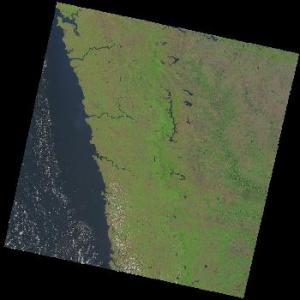


Each image is of about 185 km x 180 km and around 8000 x 8000 pixels (which varies from scene to scene) size with the resoulution ranging from 30m to about 100m from band to band. The GeoTiff image is an array of pixel intesities, tagged along with geospacial data as well as some metadata pertaining to Loactions, transformations and time stamps. Which is completely reasonable as the Scene cannot treated as a planar surface at these scales. This makes the problem trickier than any other traditional image processing problems.

<center>


### Methodology

</center>

Our algorithm on a higher level finds the water body in the pixel space and gets a bounding region around it. Then this bounding region is projected back in the geodesic coordinates to clip the GeoTiff file in our Region of interest. Then an unsupervised classification algorithm clusters the pixels in the Region of Interest. The algorithm then identify the cluster that represents the water body and report the its area. The detailed algorithm is as below:

Inputs: Path, Row, timeFrame, cloud cover, ReqX, ReqY
Hyperparameters: offset, numClusters, numPixels, varBound
- Set: $imageCollection \leftarrow$ as a set of Scenes for the given (Path, Row, timeFrame, cloud cover). [1](#Aquiring-Images)
- Set: $minCC :=$ Index of Scene with minimum cloud cover $\in imageCollection$ [2](#Finding-the-minCC)
- Set: $image_{minCC} \leftarrow$ ImageCollection\[minCC\] as numpy.ndarray [3](#Converting-$image_{minCC}$-to-np.ndarray)
- Identify: $cnt \leftarrow$ as a set of contours in $image_{minCC}$ [4](#Helper-function:-detecting-Contours,-Rectangles)
- Set: $contour_{required}:= argmin_{i} Distance((reqX, reqY), centre_{contour_i})$ for $contour_i \in cnt$ [4](#Helper-function:-detecting-Contours,-Rectangles)
- identify: $ rect_{required}:=[x, y, width, height] $ for the bounding rectangle of $contour_{required}$ with offset [4](#Helper-function:-detecting-Contours,-Rectangles)
- Project: $roi := rect_{required} $ as an earth engine object.[5](#Reprojecting-to-the-geographic-space)
- Sample: sampleTraining := points $ \in image_{minCC}$ as set. $\|sampleTraining\| = numPixels$ [6](#Getting-Training-Sasmple)
- Train: classifier on the for numClusters over $sampleTraining$ [6](#Getting-Training-Sasmple)
- For each $image \in imageCollection$ :
    - Clip: $image$ to $Roi$
    - Classify: $points \in image$ into numClusters
    - Set: $kNDWI := \{ Ndwi_i\}_{i = 0}^{numClusters}$ [7](#Helper-Function:-Calculating-the-NDWI-for-each-layer)
    - $waterCluster := max_{i}(kNDWI)$
    - Compute: $area_{image} := PixelArea(waterCluster)$.[8](#Helper-Function:-Cluster-Area-calculator)
    - if $(area_{image} - area_{image_{minCC}}) \leq varBound$:
        - $areaHistory \leftarrow area_{image}$
    - End of if
- End of For
- Plot: $AreaHistory$ [9](#Plotting-the-Results)

<center>


### Conventions

</center>

The local variables identifiers are in camel case with lowercase initials $trainingSample$. Functions are in camel case with uppercase initials $ProjectRect$. Global variables are in All capitals. The program is will work in python3.x and will use following packages:
- [numpy](https://numpy.org/)
- [ee](https://developers.google.com/earth-engine/guides/python_install#install-options) 
  For using any method in Earth engine library, an Earth Engine [account](https://earthengine.google.com/) is needed.  
- [IPython.display](https://ipython.org/)
- [matplotlib](https://matplotlib.org/)
- [geemap](https://github.com/giswqs/geemap)
- [cv2](https://docs.opencv.org/master/d0/de3/tutorial_py_intro.html)
- [math](https://docs.python.org/3/library/math.html)
- [urllib](https://docs.python.org/3/library/urllib.html)

### Library import 

In [1]:
import geemap as emap
import ee
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import datetime as dt
import matplotlib.dates as mdates
#-------------000-------------#
ee.Authenticate()

ee.Initialize()

Enter verification code: 4/4AFbuBzsvYoYoHV8Aw0A6mB43dyJe0KfNfX1AszL6T_9-3z9epUpm5E

Successfully saved authorization token.


#### Helper Function: Appending the NDWI band

In [2]:
def AddNdwi(image):
    '''
    Add NDWI := (B5 - B4)/(B5 + B4) band to the image
    '''
    ndwi  = image.normalizedDifference(['B5', 'B4']).rename('NDWI')
    return image.addBands(ndwi)

### Acquiring Images

In [3]:
path      = [16]
row       = [30] 
satellite = 'LANDSAT/LC08/C01/T1_TOA'  
startDate = '2013-05-01'               # yyyy-mm-dd
endDate   = '2020-09-01'               # yyyy-mm-dd
cloudCover= 10                         # percent

coll = ee.ImageCollection(satellite).filterDate(startDate, endDate)\
        .filter(ee.Filter.inList('WRS_PATH', path))\
        .filter(ee.Filter.inList('WRS_ROW', row))\
        .filter(ee.Filter.lt('CLOUD_COVER', cloudCover))

imageIds        = list(map(lambda x: x['id'], coll.getInfo()['features']))
images          = list(map(lambda x: ee.Image(x), imageIds))
imageCollection = list(map(AddNdwi, images))
dates           = [image.getInfo()['properties']['DATE_ACQUIRED'] for image in imageCollection]

### Finding the minCC

In [4]:
cc    = [image.get("CLOUD_COVER").getInfo() for image in images]       # cloud cover score for each image
minCC = cc.index(min(cc))

print('Image with minimum cloud cover: ', minCC, "\nminimum Cloud Cover: ", cc[minCC], " %")

Image with minimum cloud cover:  10 
minimum Cloud Cover:  0.009999999776482582  %


### Converting $image_{minCC}$ to np.ndarray

#### Helper Function

In [5]:
def urlToImage(eeImage, minVal, maxVal, dim):
    '''
    download the image, convert it to a NumPy array, and then read it into np.ndarray format.
    minVal and maxVal are uselful in contrast stretching the image. 
    dim is the dimension of the resulting thumbnail image
    '''
    from urllib.request import urlopen
    url   = eeImage.getThumbURL({'min': minVal,
                                'max': maxVal,
                                'dimensions': dim})
    resp  = urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # return the image
    return image

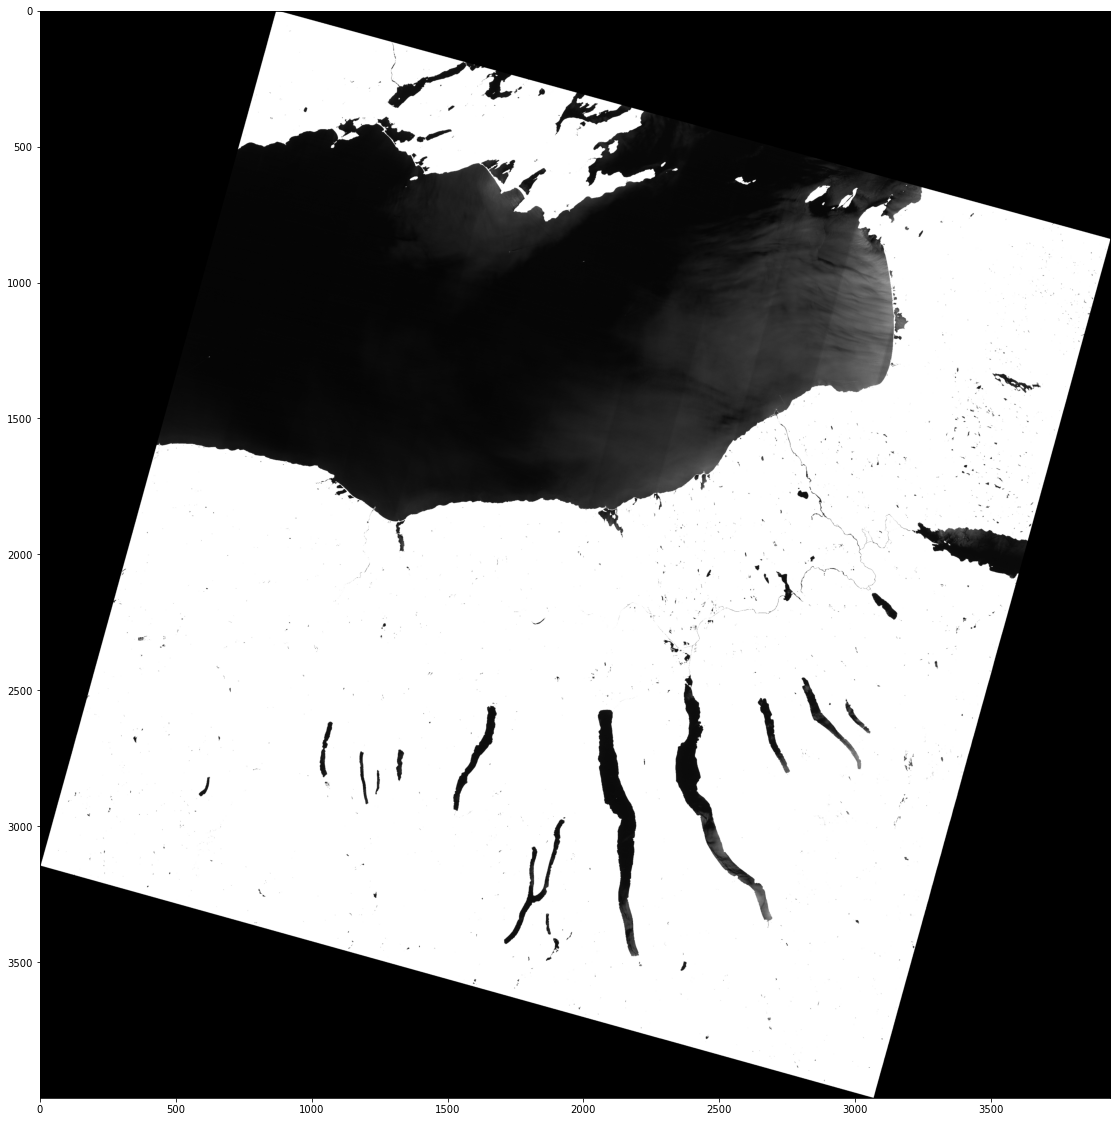

In [6]:
# Select one representative image for slicing
image = images[minCC].select(['B7'])

# Set Image Visualization Parameters and get a URL for the corresponding Thumb Nail
# Convert Image to a Opencv image from the ThumbURL
image = urlToImage(image, 1e-8, 0.03, 4000)
# image is a numpy array, I can use for contouring.
# Though, when visualized it will look like a Grayscale image, it is actually
# an RGB image 

# Display the image
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.show()

### Getting the region of interest

#### Helper function: detecting Contours, Rectangles

In [7]:
def RoiInPixelSpace(npImage, offset):
    backup= np.copy(npImage)
    gray = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)
    imgX, imgY = np.shape(gray)

    edged = cv2.Canny(gray, 100, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    offset = offset * 2
    rect = []   #rect has the list of all allowable rectangles#
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)

        if cv2.contourArea(cnt) > 200:
            rect.append([x,y,w,h])
    
    return rect, contours, backup

#======================================================================================#
def GetRect(req_x, req_y, offset, rect, contours, img):
    """Get the closest rectangle to the reqested x and y"""
    i = GetClosestWaterBody(req_x, req_y, rect)
    x, y, w, h = rect[i]
    (x, y, w, h) = (x-offset, y-offset, w+2*offset, h+2*offset)
    PlotRectPoint(x, y, w, h, req_x, req_y, offset, contours[i], img)
    return x, y, w, h

#======================================================================================#
def GetClosestWaterBody(reqX, reqY, rect):
    '''
    This function will return the index of the closest bounding rectangle of the 
    water body to the required point
    '''
    minDist = float("inf")
    minDistIndex = None
    for i in range(len(rect)):
        if rect[i][2] * rect[i][3] < 500:
            continue
        d = DistRect(reqX, reqY, rect[i][0], rect[i][1], rect[i][2], rect[i][3])
        if d < minDist:
            minDist = d
            minDistIndex = i
    return minDistIndex

#======================================================================================#
def PlotRectPoint(x, y, w, h, x1, y1, offset, contours, img):
    imgCpy = img.copy()
    offset = int(offset/2)
    cv2.rectangle(imgCpy,(x - offset,y - offset), (x + w + offset, y + h + offset), (0,255,0),2)
    cv2.circle(imgCpy, (x1, y1), radius=10, color=(0, 0, 255), thickness=-1)
    cv2.drawContours(imgCpy, [contours], -1, (255, 255, 0), 2)
    plt.figure(figsize=(20,20))
    plt.imshow(imgCpy)
    plt.show()

#======================================================================================#
L2Norm   = lambda x1, y1, x2, y2 : math.sqrt((x1-x2)**2 + (y1-y2)**2)
DistRect = lambda x1, y1, x, y, w, h: L2Norm(x1, y1, (x + 0.5 * w), (y + 0.5 * h))

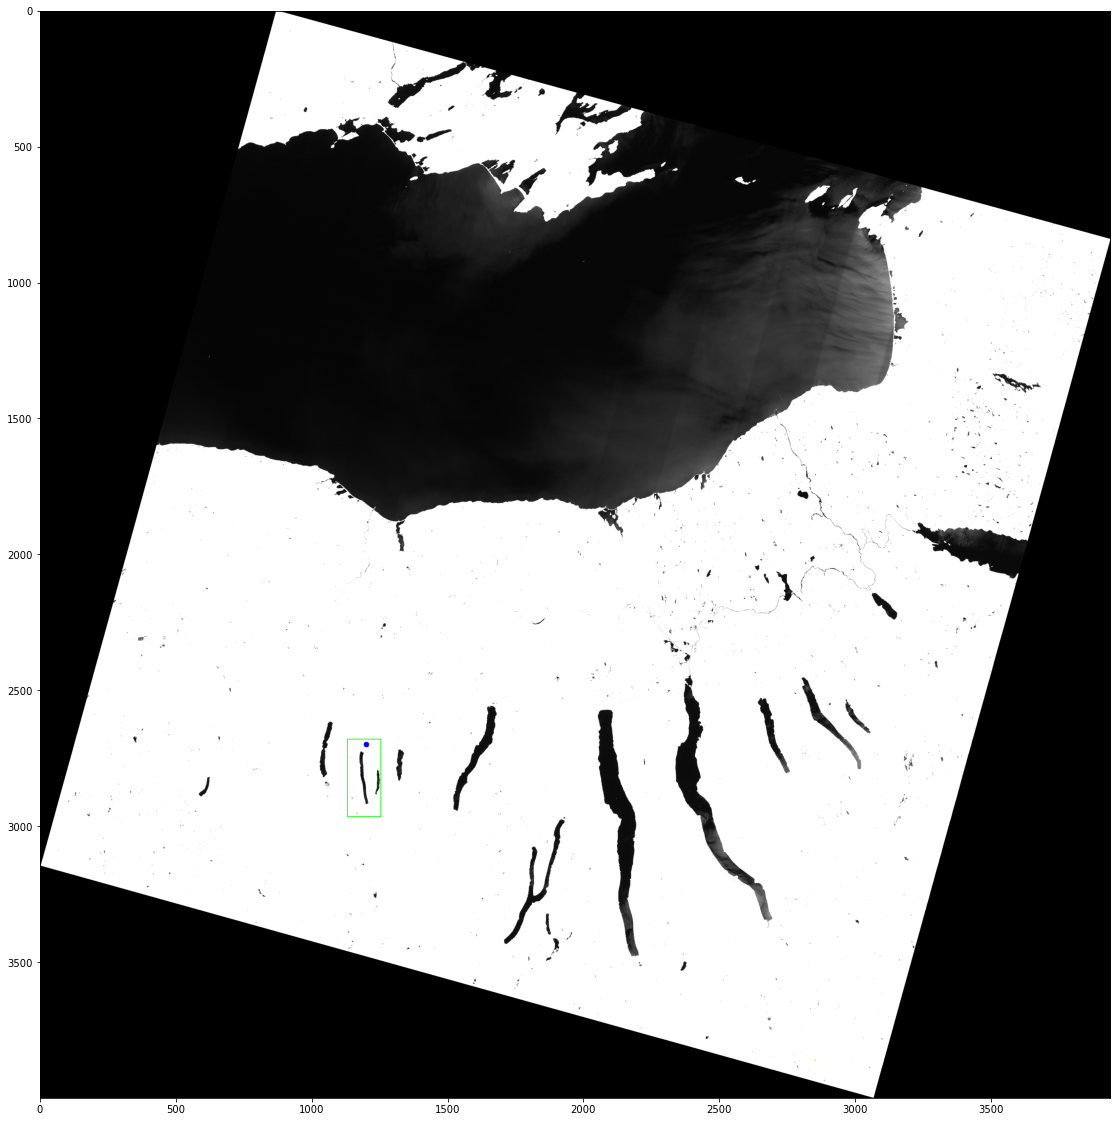

In [8]:
offset =  30   #param {type:"integer"}

#Origin is in the top left corner
#Increasing reqX to move the point right
#Increasing reqY to move the point right
reqX  =  1200 #param {type:"integer"}
reqY  =  2700 #param {type:"integer"}

rect, contours, backup = RoiInPixelSpace(image, offset)
x, y, w, h = GetRect(reqX, reqY, offset, rect, contours, image)

### Reprojecting to the geographic space

#### Helper Function: Reprojection

In [9]:
def ImageToGeeProjection(geeImage, imgBounds, arrayImage):
    '''
    Takes image of type ee.Image, list of format [x, y, width, height] and the arrayImage of type numpy.ndarray
    as an input and returns a ee.geometry region of interest  
    '''
    Region         = geeImage.geometry().bounds().getInfo()
    Vertices       = Region['coordinates'][0][0:4]
    Origin         = Region['coordinates'][0][0]

    pixelY, pixelX = geeImage.select(["B1"]).toArray().getInfo()['bands'][0]['dimensions']
    imgX, imgY, _  = np.shape(arrayImage) 
    x, y, w, h     = imgBounds
    
    xDist          =(Vertices[2][0] - Vertices[0][0])*(x / imgX)
    deltaxDist     =(Vertices[2][0] - Vertices[0][0])*((x+w)/imgX)

    yDist          =(Vertices[2][1] - Vertices[0][1])*(y / (imgY))
    deltayDist     =(Vertices[2][1] - Vertices[0][1])*((y+h)/(imgY))

    Bounds         = [Vertices[0][0] + xDist, 
                      Vertices[2][1] - yDist, 
                      Vertices[0][0] + deltaxDist, 
                      Vertices[2][1] - deltayDist]
    
    return ee.Geometry.Rectangle(Bounds)

In [10]:
Roi = ImageToGeeProjection(imageCollection[minCC], [x, y, w, h], backup)

Map = emap.Map()
Map.addLayer(images[minCC].select(['B5', 'B4', 'B3']).clip(Roi), {'min': 0, 'max': 0.3, 'opacity':0.95}, 'Base')
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

Sample Output:

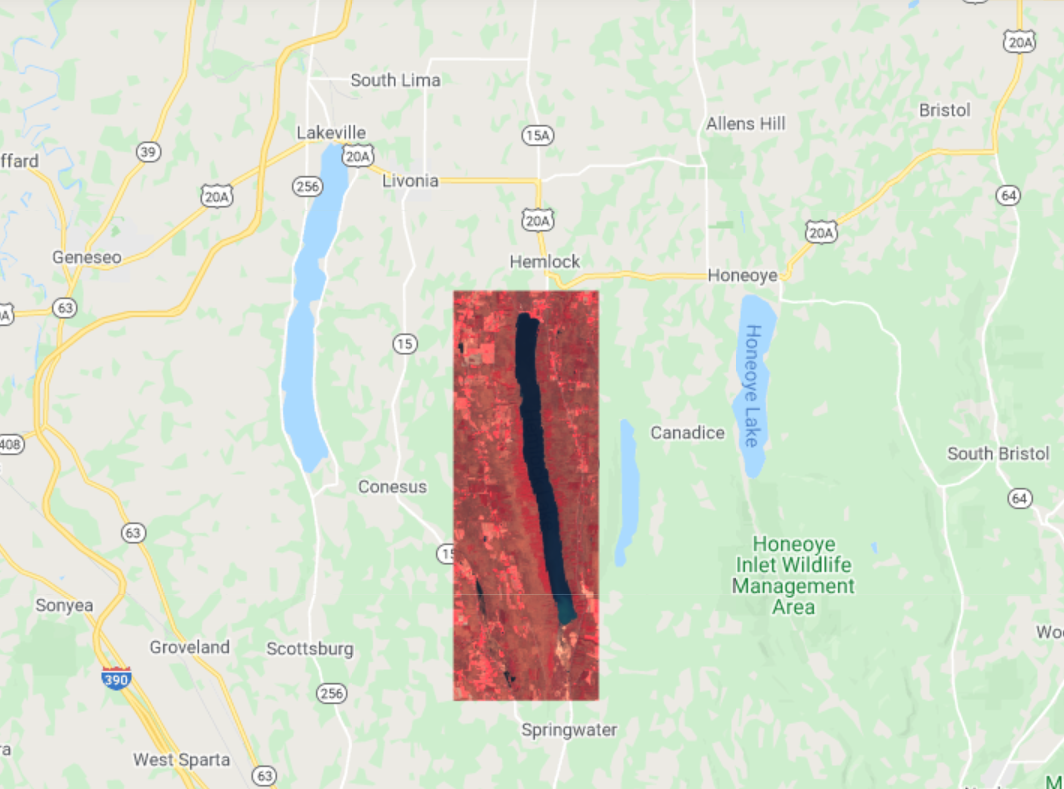

### Kmeans Training

#### Helper Function: Cluster Area calculator

Though the [algorithm](#Methodology) suggests we find the are of the layer with maximum NDWI, we will select the layer that has the minimum NDWI. The reason lies in the actual implementation of the algorithm.

We are actually masking the layer pixels and then calculating the NDWI for the remainder of the pixels in the Region of Interest (Roi). As the water pixels significantly add to the mean of the layer, the image that has all the water pixels masked will have the least smallest NDWI that any other image which has some or all the water pixels unmasked. 

The maximum NDWI logic can still be applied, but we will need to do two-fold masking of the image, which will add a serial operation for each iteration, and the speed of the algorithm will thus take a hit.

In [11]:
def ClusterAreaCalc(geeImage, Roi, numCluster, j):
    sampleTraining = geeImage.select(["B4", 'B5', "NDWI"]).sample(scale = 30.0, numPixels = 500)
    numCluster  = 2
    clusterer   = ee.Clusterer.wekaKMeans(numCluster).train(sampleTraining)
    Clusters    = geeImage.select(["B4", 'B5', "NDWI"]).cluster(clusterer)
    clusterBand = geeImage.cluster(clusterer).rename("Clusters")
    AugImage    = geeImage.addBands(clusterBand)
    LayerNDWI   = lambda i: NdwiScore(AugImage, Roi, i)
    kNdwi       = list(map(LayerNDWI, list(range(numCluster))))

    waterNDWI   = float('inf')
    for i in range(len(kNdwi)):
        if kNdwi[i] != None and kNdwi[i] < waterNDWI:
            waterNDWI = kNdwi[i]
            waterCluster = i
    
    water       = Clusters.select("cluster").eq(waterCluster).selfMask()
    Map.addLayer(water.clip(Roi), {"min" : 0, "max": 1, 'palette': ['red', 'blue'],}, str(j))
    areaWater   = water.multiply(ee.Image.pixelArea()).divide(1000*1000)

    area        = areaWater.reduceRegion(reducer  =ee.Reducer.sum(),
                                    geometry = Roi,
                                    scale    = 30, 
                                    maxPixels= 1e13)
    return area.getInfo()['cluster']

AreaCalculator = lambda geeImage: ClusterAreaCalc(geeImage, Roi, 2, imageCollection.index(geeImage))

#### Helper Function: Calculating the NDWI for each layer

In [12]:
def NdwiScore(geeImage, Roi, i):
    dataMask = geeImage.select(['Clusters'])
    mask = dataMask.eq(i)
    maskedComposite = geeImage.clip(Roi).updateMask(mask)
    return maskedComposite.reduceRegion(
                                         reducer= ee.Reducer.mean(),
                                         geometry=Roi,
                                         scale= 30
                                       ).getInfo()['NDWI']

In [13]:
Map = emap.Map()
label = list(range(len(imageCollection)))
areaHistory = list(map(AreaCalculator, imageCollection))
timeStamp   = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

## Plotting the Results

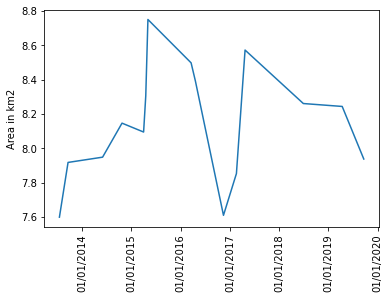

In [14]:
refArea = areaHistory[minCC]
areaHistoryPruned = [[timeStamp[i], areaHistory[i]]  for i in range(len(areaHistory)) if abs((areaHistory[i] - refArea)/refArea) < 0.1]

plt.ylabel("Area in km2")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.plot(*zip(*areaHistoryPruned))
plt.show()

<center>

### Conclusion
    
The script above will help you bound a region around the water body of users' interest and analyse the Surface Area occupied by that body for any duration user specifies while creating the image collection. Furthermore, the not only water bodies, the above algorithm can also be scaled to study other geographic features like, Vegetation cover using NDVI (Normalized Difference Vegetation Index); Snow cover using NDSI (Normalized Difference Snow Index), etc. 

Such type of analyses make sense in academic and agricultural settings but also create an awareness about how the combined actions of Humans and Nature are affecting our resources. 


<center>

### Conclusion

</center>

1. The Spectral bands in visible region and their corresponding wavelengths along with resolution are as follows:
    - Band 1 Visible (0.43 - 0.45 µm) 30 m
    - Band 2 Visible (0.450 - 0.51 µm) 30 m
    - Band 3 Visible (0.53 - 0.59 µm) 30 m
    - Band 4 Red (0.64 - 0.67 µm) 30 m
    - Band 5 Near-Infrared (0.85 - 0.88 µm) 30 m
    - Band 6 SWIR 1(1.57 - 1.65 µm) 30 m
    - Band 7 SWIR 2 (2.11 - 2.29 µm) 30 m
    - Band 8 Panchromatic (PAN) (0.50 - 0.68 µm) 15 m
    - Band 9 Cirrus (1.36 - 1.38 µm) 30 m
    
1. The Two Spectral bands in the Infrared region along with their wavelengths and resolution are as follows:
    - Band 10 TIRS 1 (10.6 - 11.19 µm) 100 m
    - Band 11 TIRS 2 (11.5 - 12.51 µm) 100 m